## Install & Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load processed data

In [2]:
train_df = pd.read_csv("../data/processed/train.csv")
val_df   = pd.read_csv("../data/processed/val.csv")
test_df  = pd.read_csv("../data/processed/test.csv")

train_df["text"] = train_df["text"].astype(str)
val_df["text"]   = val_df["text"].astype(str)
test_df["text"]  = test_df["text"].astype(str)

print(train_df.shape, val_df.shape, test_df.shape)
train_df.head()

(35918, 2) (4490, 2) (4490, 2)


,text,label
0,trump asks supreme court to block travel ban r...,0
1,insight emails show how republicans lobbied to...,0
2,jailed british iranian charity worker received...,0
3,trump gets torn to shreds after his fake news ...,1
4,trump offers support for bathroom access based...,0


## Convert ke HuggingFace Dataset

In [3]:
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

## Tokenizer + Tokenization

In [4]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 256

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok   = val_ds.map(tokenize_fn, batched=True)
test_tok  = test_ds.map(tokenize_fn, batched=True)

# Trainer butuh kolom label
train_tok = train_tok.rename_column("label", "labels")
val_tok   = val_tok.rename_column("label", "labels")
test_tok  = test_tok.rename_column("label", "labels")

# drop kolom yang tidak dipakai Trainer
cols_to_remove = [c for c in train_tok.column_names if c not in ["input_ids", "token_type_ids", "attention_mask", "labels"]]
train_tok = train_tok.remove_columns(cols_to_remove)
val_tok   = val_tok.remove_columns(cols_to_remove)
test_tok  = test_tok.remove_columns(cols_to_remove)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 4490/4490 [00:01<00:00, 3668.51 examples/s]


## Build model BERT (binary classification)

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Device:", device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


## Metrics (untuk Trainer)

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

## TrainingArguments + Trainer

In [7]:
import os
os.makedirs("../models/bert", exist_ok=True)

training_args = TrainingArguments(
    output_dir="../models/bert/checkpoints",
    eval_strategy="epoch",          # ✅ ganti dari evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,

    logging_dir="../models/bert/logs",
    logging_steps=50,

    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20744\4152913744.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train

In [8]:
train_output = trainer.train()
train_output

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.007429,0.998886,0.998723,0.999148,0.998935
2,0.000000,0.003591,0.999555,0.999149,1.000000,0.999574


TrainOutput(global_step=8980, training_loss=0.00976658316592871, metrics={'train_runtime': 4094.7223, 'train_samples_per_second': 17.544, 'train_steps_per_second': 2.193, 'total_flos': 9450422886420480.0, 'train_loss': 0.00976658316592871, 'epoch': 2.0})

## Plot Loss (dari log Trainer)

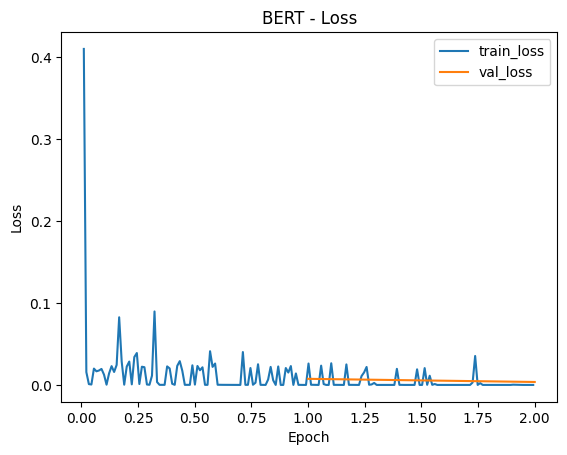

In [9]:
logs = trainer.state.log_history
train_losses = [x["loss"] for x in logs if "loss" in x and "epoch" in x]
train_epochs = [x["epoch"] for x in logs if "loss" in x and "epoch" in x]

eval_losses = [x["eval_loss"] for x in logs if "eval_loss" in x and "epoch" in x]
eval_epochs = [x["epoch"] for x in logs if "eval_loss" in x and "epoch" in x]

plt.figure()
if len(train_losses) > 0:
    plt.plot(train_epochs, train_losses, label="train_loss")
if len(eval_losses) > 0:
    plt.plot(eval_epochs, eval_losses, label="val_loss")
plt.title("BERT - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluate on Test (Classification Report + Confusion Matrix)

Classification Report (BERT):
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      2142
        Fake       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



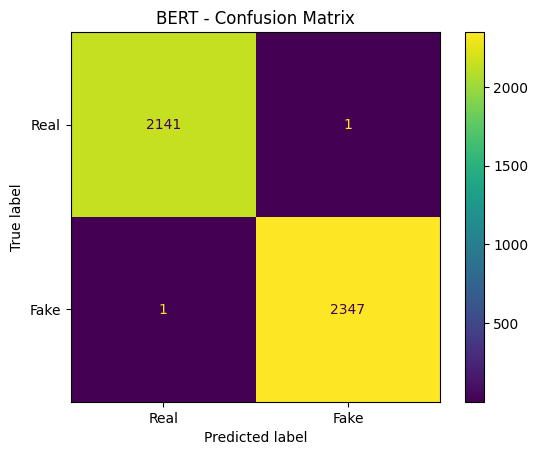

In [10]:
pred = trainer.predict(test_tok)
logits = pred.predictions
y_true = pred.label_ids
y_pred = np.argmax(logits, axis=-1)

print("Classification Report (BERT):")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot()
plt.title("BERT - Confusion Matrix")
plt.show()

## Save final model + tokenizer (untuk Streamlit)

In [11]:
save_dir = "../models/bert/final"
os.makedirs(save_dir, exist_ok=True)

trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Saved BERT model & tokenizer to:", save_dir)

Saved BERT model & tokenizer to: ../models/bert/final
